In [40]:
def span_2_time(ts): 
    assert len(ts)>30,"time span too short"
    t=[0]*len(ts)
    for i in range(1,len(t)):
        t[i]=t[i-1] + ts[i]
    return t
def time_2_span(t):
    assert len(t)>30,"time too short"
    span=[0]*len(t)
    for i in range(0,len(t)-1):
        span[i+1]=t[i+1]-t[i]
    return span

In [402]:
import redis
import json
def get_raw_data():
    rds = redis.StrictRedis(host='docker.vm', port=6379, db=15)
    for key in rds.scan_iter("1*"):
        key=key.decode("ascii")
        data=rds.get(key)
        js=json.loads(data.decode("ascii"))
        acelerations,tm,label=js["accelero"],js["time"],js["label"]   
                
        assert len(acelerations)==3*len(tm),"data corrupt"
        assert len(tm)==len(label),f"{key} label  {len(label)} timespan {len(tm)} corrupt "
        yield key,acelerations,tm, label
           
    yield None,None,None,None

g=get_raw_data()
data_pool=[]
while True:
    start_time,acelerations,tm,label=next(g) 
    if start_time ==None:
        break
    abadom=False
    for v in acelerations:
        if v> 6:
            abadom=True
            break
    if abadom:continue
    
    if len([v for v in label if v!=0])<23:
        continue
    data_pool.append([start_time,acelerations,tm,label])

In [377]:
len(data_pool)

18

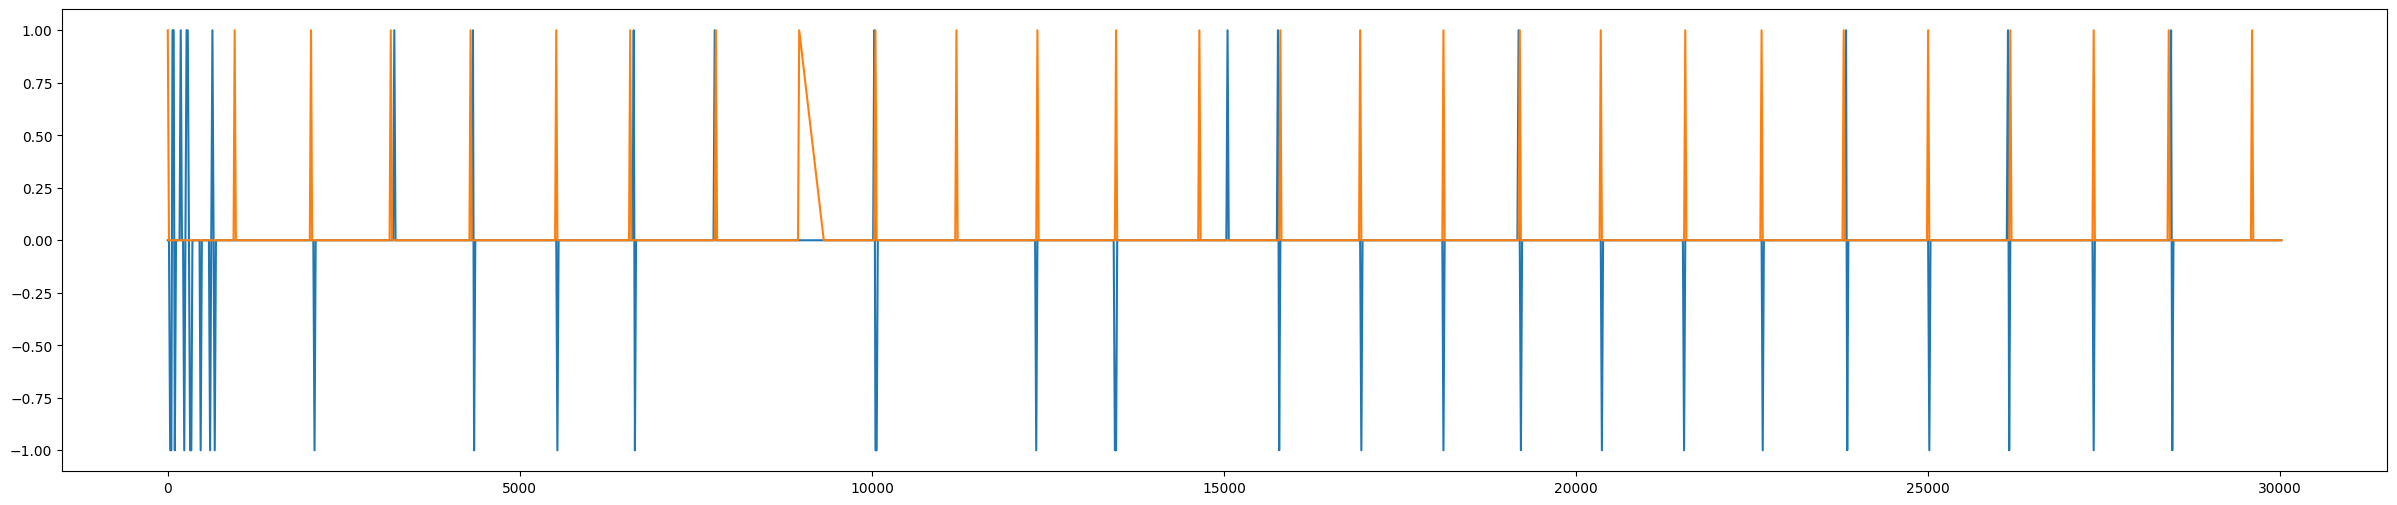

In [401]:
d=random.choice(data_pool)
ace=[v for i,v in enumerate(d[1]) if i%3==1]
tm=d[2]
label=d[3]
plt.figure(0,figsize=(30, 6))
plt.plot(tm,ace)
plt.plot(tm,label)
plt.show()

In [370]:
import random
import numpy as np
PointsPS=200 #data_points_per_second #每秒200格精度
time_seconds=4
labelGrids=32*time_seconds
dataGrids=PointsPS*time_seconds
    
def get_training_data():
    while True:
        #start_time,acelerations,timespan,label=random.choice(data_pool)
        #acelerations 的原始时间精度是不确定的，可能是50-60hz每秒，也可能是200hz每秒，也可能是1000hz每秒
        start_time,acelerations,tm,label=random.choice(data_pool)
        ts=tm[-1]-tm[0]
        time_window_span=time_seconds*1000
        if ts<time_window_span:
            continue
        
        grids=PointsPS*time_seconds
        if ts<time_window_span:
            continue
        tsb=random.random()*(ts-time_window_span)
        if tsb<0 :
            continue  
        
        #目标数据时间段的起始index，终了index
        indexB=-1
        for i,t in enumerate(tm):
            if t>=tsb:
                tsb=t
                indexB=i
                break
        if indexB==-1:
            continue
        indexEnd,timeEnd=-1,tsb+time_window_span
        for i in range(indexB+1,len(tm)):
            if tm[i]<timeEnd:
                indexEnd=i
                continue
            break
        if indexEnd==-1:
            continue
        #重新微调时间段，以便能够用来可靠计算下标
        real_time_span=tm[indexEnd]-tm[indexB]
                
        # 开始对加速度做编码
        #先写入所有信息
        times=[]
        x,y,z=[],[],[]
        window=[0]*PointsPS*time_seconds*3#每个时间点有3个数据   
        for i in range(indexB,indexEnd+1):
            t=tm[i]
            times.append(t-tsb)
            x.append(acelerations[i*3])
            y.append(acelerations[i*3+1])
            z.append(acelerations[i*3+2])
            
        #其余点插值补足
        time_wanted=[real_time_span * i/(PointsPS*time_seconds-1) for i in range(PointsPS*time_seconds)]
        x=np.interp(time_wanted, times, x)
        x=x-np.mean(x)
        y=np.interp(time_wanted, times, y)
        y=y-np.mean(y)
        z=np.interp(time_wanted, times, z)
        z=z-np.mean(z)
        data_xyz=[x,y,z]
        #random.shuffle(data_xyz)
        
        # 对标签做编码,二值标签。仅当label[j]、label[j+1]为1时，目标Label[j/2]==1
        # 精度每秒1/32. 考虑到数据有4秒，那么平均误差每秒1/128
        traning_label=[0]*labelGrids
        for i in range(indexB,indexEnd+1):
            if label[i]!=0:
                dex_ind=int((tm[i]-tsb)*(labelGrids-1)/real_time_span)
                traning_label[dex_ind]=1.0
                #把周围的其它六个点也设置成标亮
                for di in range(max(dex_ind-2,0),min(dex_ind+2,labelGrids-1)):
                    traning_label[di]=1.0
                
        yield np.array(data_xyz),np.array(traning_label)
def load_data():
    data_generator=get_training_data()
    
    x_train,y_train=[],[]
    for i in range(30000):
        data,label=next(data_generator)
        x_train.append(data)
        y_train.append(label)
        
    return (np.array(x_train,dtype="float32"), np.array(y_train,dtype="float32"))
#print(len(window),window,"\n",len(label),label,)

In [371]:
# Prepare the training dataset
x_train_DATA, y_train_DATA = load_data()

In [360]:
i

13848

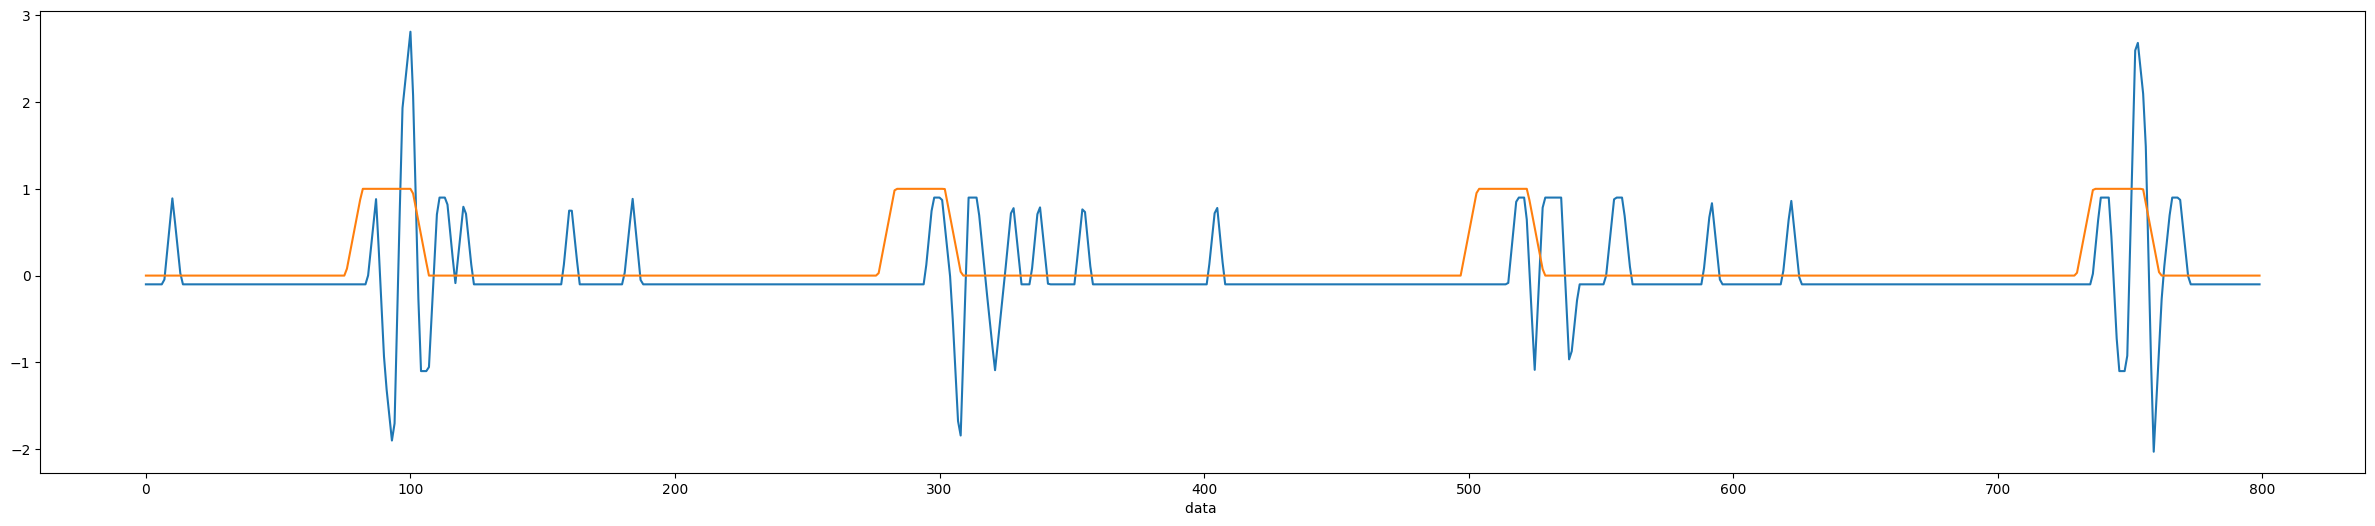

In [375]:
import random
i=int(random.random()*len(x_train_DATA))
x_DATA=x_train_DATA[i]
y_DATA=y_train_DATA[i]

t=[i for i in range(len(x_DATA[0]))]
plt.figure(0,figsize=(30, 6))
plt.xlabel(f"data ")
#plt.plot(t,xx)
#plt.plot(t,x_DATA[1])
plt.plot(t,x_DATA[2])
y=np.interp([(labelGrids-1)*i/(dataGrids-1) for i in range(dataGrids)], [v for v in range(labelGrids)], y_DATA)
plt.plot(t,y)
plt.show()

In [ ]:
# Reserve 10,000 samples for validation.
x_val = x_train[-800:]
y_val = y_train[-800:]
x_train = x_train[:-800]
y_train = y_train[:-800]

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
batch_size = 4096

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=16384).batch(batch_size)

# Prepare the validation dataset.

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [347]:
#https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c
# import necessary layers  
from tensorflow.keras.layers import Input,  Conv1D 
from tensorflow.keras.layers import MaxPool1D, Flatten, Dense 
from tensorflow.keras import Model
# input

input = Input(shape =(3,PointsPS*6),dtype="float32")
# 1st Conv Block

x = Conv1D (filters =64, kernel_size =6, padding ='same', activation='relu')(input)
x = Conv1D (filters =64, kernel_size =16, padding ='same', activation='relu')(x)
x = MaxPool1D(pool_size =2, strides =2, padding ='same')(x)
# 2nd Conv Block

x = Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool1D(pool_size =2, strides =2, padding ='same')(x)
# 3rd Conv block

x = Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool1D(pool_size =2, strides =2, padding ='same')(x)
# 4th Conv block

# x = Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
# x = Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
# x = Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
# x = MaxPool1D(pool_size =2, strides =2, padding ='same')(x)

# # 5th Conv block

# x = Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
# x = Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
# x = Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
# x = MaxPool1D(pool_size =2, strides =2, padding ='same')(x)
# Fully connected layers

x = Flatten()(x)
x = Dense(units = 512, activation ='relu')(x)
x = Dense(units = 512, activation ='relu')(x)
output = Dense(units = 192, activation ='softmax')(x)
# creating the model

model = Model (inputs=input, outputs =output)
#model.load_weights("model_epoch4")
#model.summary()

In [352]:
import time
import tensorflow as tf
from tensorflow.keras.losses import Hinge
# Prepare the metrics.

# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-4)
# Instantiate a loss function.BinaryFocalCrossentropy
#loss_fn = keras.losses.Hinge(from_logits=False)
loss_fn = keras.losses.Hinge()
# # Prepare the metrics.
train_acc_metric = tf.keras.metrics.Hinge(
    name='binary_crossentropy',
    dtype=None,
    #from_logits=False,
    #label_smoothing=0
)
val_acc_metric = tf.keras.metrics.Hinge(
    name='binary_crossentropy',
    dtype=None,
    #from_logits=False,
    #label_smoothing=0
)

epochs = 10
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits =  model(inputs=x_batch_train, training=True)
            
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))
    model.save_weights(f"model_epoch{epoch}")


Start of epoch 0
Training loss (for one batch) at step 0: 0.9994
Seen so far: 4096 samples
Training acc over epoch: 0.9995
Validation acc: 0.9997
Time taken: 2.60s

Start of epoch 1
Training loss (for one batch) at step 0: 0.9994
Seen so far: 4096 samples
Training acc over epoch: 0.9995
Validation acc: 0.9997
Time taken: 2.29s

Start of epoch 2
Training loss (for one batch) at step 0: 0.9995
Seen so far: 4096 samples
Training acc over epoch: 0.9995
Validation acc: 0.9997
Time taken: 2.59s

Start of epoch 3
Training loss (for one batch) at step 0: 0.9995
Seen so far: 4096 samples
Training acc over epoch: 0.9995
Validation acc: 0.9997
Time taken: 2.70s

Start of epoch 4
Training loss (for one batch) at step 0: 0.9995
Seen so far: 4096 samples
Training acc over epoch: 0.9995
Validation acc: 0.9997
Time taken: 2.60s

Start of epoch 5
Training loss (for one batch) at step 0: 0.9995
Seen so far: 4096 samples
Training acc over epoch: 0.9995
Validation acc: 0.9997
Time taken: 2.24s

Start of 

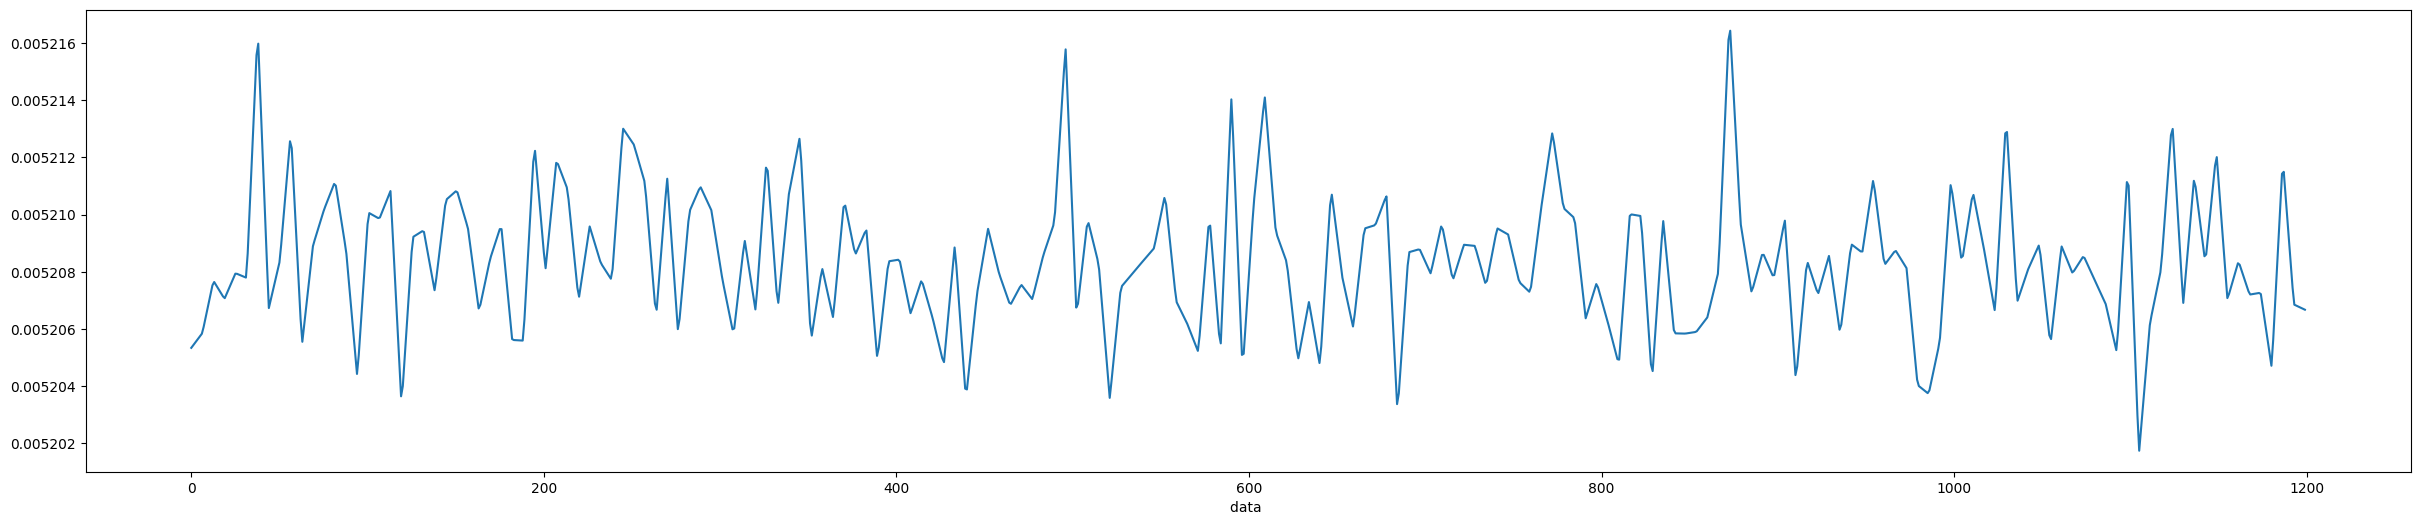

logits=[0.00520533 0.00520585 0.00520768 0.00520705 0.00520795 0.00520779
 0.00521651 0.00520671 0.00520838 0.00521293 0.00520542 0.00520892
 0.00521018 0.00521117 0.0052087  0.00520431 0.00521007 0.00520985
 0.00521083 0.00520331 0.00520921 0.00520945 0.00520732 0.00521051
 0.00521085 0.00520953 0.00520662 0.00520844 0.00520964 0.00520561
 0.00520559 0.00521252 0.00520805 0.00521191 0.00521089 0.00520701
 0.00520959 0.00520831 0.0052077  0.00521302 0.00521245 0.0052111
 0.0052064  0.00521132 0.00520581 0.0052101  0.00521099 0.00521015
 0.00520772 0.0052058  0.00520913 0.00520662 0.00521201 0.00520673
 0.00521071 0.00521274 0.00520558 0.00520814 0.00520639 0.00521051
 0.00520859 0.0052095  0.00520491 0.00520836 0.00520843 0.00520654
 0.00520772 0.00520637 0.00520475 0.00520895 0.00520354 0.00520722
 0.00520951 0.00520793 0.00520682 0.00520755 0.00520704 0.00520858
 0.00520974 0.0052159  0.00520644 0.00520983 0.00520826 0.00520356
 0.00520745 0.00520792 0.00520837 0.00520882 0.00521071 

In [353]:
window=[0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 1, 0, 0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, -0.3333333333333333, 0.0, 0.3333333333333333, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.3333333333333333, 0.0, -0.3333333333333333, 0.6666666666666666, 0, 0, 1, 0.0, 0.0, 0.75, 0.0, 0.0, 0.5, 0.0, 0.0, 0.25, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 1, 0, 0, 0.75, -0.25, 0.0, 0.5, -0.5, 0.0, 0.25, -0.75, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, -0.25, 0.0, 0.0, -0.5, 0.0, 0.0, -0.75, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, -0.25, 0.0, 0.0, -0.5, 0.0, 0.0, -0.75, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.5, 0.0, 0.0, 0.75, 0, 0, 1, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0, 0, 0, 0.0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0, 0, -1, -0.25, -0.25, -0.75, -0.5, -0.5, -0.5, -0.75, -0.75, -0.25, -1, -1, 0, -0.6666666666666666, -1.0, 0.6666666666666666, -0.3333333333333333, -1.0, 1.3333333333333333, 0, -1, 2, 0.0, -0.6666666666666666, 1.6666666666666665, 0.0, -0.3333333333333333, 1.3333333333333333, 0, 0, 1, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5, 0, 0, -1, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0, 0, -1, 0.0, -0.25, -1.0, 0.0, -0.5, -1.0, 0.0, -0.75, -1.0, 0, -1, -1, 0.0, -1.0, -0.6666666666666666, 0.0, -1.0, -0.3333333333333333, 0, -1, 0, 0.0, -0.6666666666666666, 0.3333333333333333, 0.0, -0.3333333333333333, 0.6666666666666666, 0, 0, 1, 0.0, 0.0, 0.75, 0.0, 0.0, 0.5, 0.0, 0.0, 0.25, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0, 0, -1, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0, 0, -1, 0.3333333333333333, 0.0, -0.3333333333333333, 0.6666666666666666, 0.0, 0.3333333333333333, 1, 0, 1, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1, 0, 1, 0.75, -0.25, 0.75, 0.5, -0.5, 0.5, 0.25, -0.75, 0.25, 0, -1, 0, -0.3333333333333333, -0.6666666666666666, -0.3333333333333333, -0.6666666666666666, -0.3333333333333333, -0.6666666666666666, -1, 0, -1, -0.6666666666666666, 0.0, -0.6666666666666666, -0.3333333333333333, 0.0, -0.3333333333333333, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -1.0, -0.25, 0.0, -1.0, -0.5, 0.0, -1.0, -0.75, 0, -1, -1, 0.0, -0.6666666666666666, -0.6666666666666666, 0.0, -0.3333333333333333, -0.3333333333333333, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0, 0, 1, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0, 0, 1, 0.0, 0.0, 0.75, 0.0, 0.0, 0.5, 0.0, 0.0, 0.25, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, -0.3333333333333333, 0.0, 0.3333333333333333, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.25, 0.0, 0.0, 0.5, 0.0, 0.0, 0.75, 0.0, 0.0, 1, 0, 0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0, 0, -1, 0.0, 0.0, -0.75, 0.0, 0.0, -0.5, 0.0, 0.0, -0.25, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0, 0, -1, 0.0, 0.0, -0.75, 0.0, 0.0, -0.5, 0.0, 0.0, -0.25, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.25, 0.0, 0.0, 0.5, 0.0, 0.0, 0.75, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, -0.3333333333333333, 0.0, 0.3333333333333333, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -0.75, 0.0, 0.0, -0.5, 0.0, 0.0, -0.25, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -0.75, 0.0, 0.0, -0.5, 0.0, 0.0, -0.25, 0.0, 0, 0, 0, 0.0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0, 0, -1, 0.0, -0.3333333333333333, -1.0, 0.0, -0.6666666666666666, -1.0, 0, -1, -1, 0.0, -1.0, -0.75, 0.0, -1.0, -0.5, 0.0, -1.0, -0.25, 0, -1, 0, 0.3333333333333333, -0.3333333333333333, 1.0, 0.6666666666666666, 0.3333333333333333, 2.0, 1, 1, 3, 1.0, 0.6666666666666666, 1.6666666666666667, 1.0, 0.3333333333333333, 0.33333333333333337, 1, 0, -1, 0.75, 0.0, -1.25, 0.5, 0.0, -1.5, 0.25, 0.0, -1.75, 0, 0, -2, 0.0, -0.3333333333333333, -1.6666666666666665, 0.0, -0.6666666666666666, -1.3333333333333333, 0, -1, -1, 0.0, -1.0, -0.6666666666666666, 0.0, -1.0, -0.3333333333333333, 0, -1, 0, 0.0, -0.75, 0.0, 0.0, -0.5, 0.0, 0.0, -0.25, 0.0, 0, 0, 0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0, 0, 1, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0, 0, 1, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5, 0, 0, -1, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0, 0, -1, 0.3333333333333333, -0.3333333333333333, -0.3333333333333333, 0.6666666666666666, -0.6666666666666666, 0.3333333333333333, 1, -1, 1, 0.75, -1.0, 1.0, 0.5, -1.0, 1.0, 0.25, -1.0, 1.0, 0, -1, 1, 0.0, -1.0, 0.6666666666666666, 0.0, -1.0, 0.3333333333333333, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, -0.3333333333333333, 0.0, -0.6666666666666666, -0.6666666666666666, 0, -1, -1, 0.0, -0.6666666666666666, -0.6666666666666666, 0.0, -0.3333333333333333, -0.3333333333333333, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0, 0, 1, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0, 0, 1, 0.0, -0.3333333333333333, 0.6666666666666666, 0.0, -0.6666666666666666, 0.3333333333333333, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.25, 0.0, 0.0, 0.5, 0.0, 0.0, 0.75, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -0.75, 0.0, 0.0, -0.5, 0.0, 0.0, -0.25, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0, 0, 1, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0, 0, 1, 0.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.6666666666666666, -0.3333333333333333, 0, 1, -1, 0.3333333333333333, 0.6666666666666666, -1.0, 0.6666666666666666, 0.3333333333333333, -1.0, 1, 0, -1, 0.75, -0.25, -0.5, 0.5, -0.5, 0.0, 0.25, -0.75, 0.5, 0, -1, 1, 0.3333333333333333, -0.6666666666666666, 1.3333333333333333, 0.6666666666666666, -0.3333333333333333, 1.6666666666666665, 1, 0, 2, 0.6666666666666666, 0.0, 1.3333333333333333, 0.3333333333333333, 0.0, 0.6666666666666666, 0, 0, 0, 0.0, 0.0, -0.5, 0.0, 0.0, -1.0, 0.0, 0.0, -1.5, 0, 0, -2, 0.0, -0.3333333333333333, -1.6666666666666665, 0.0, -0.6666666666666666, -1.3333333333333333, 0, -1, -1, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0, -1, -1, 0.0, -0.75, -0.75, 0.0, -0.5, -0.5, 0.0, -0.25, -0.25, 0, 0, 0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0, 0, 1, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0, 0, -1, 0.0, -0.3333333333333333, -0.6666666666666666, 0.0, -0.6666666666666666, -0.3333333333333333, 0, -1, 0, 0.0, -1.0, 0.25, 0.0, -1.0, 0.5, 0.0, -1.0, 0.75, 0, -1, 1, 0.0, -0.6666666666666666, 0.6666666666666666, 0.0, -0.3333333333333333, 0.3333333333333333, 0, 0, 0, 0.0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0, 0, -1, 0.0, -0.25, -0.75, 0.0, -0.5, -0.5, 0.0, -0.75, -0.25, 0, -1, 0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0.0, 0, -1, 0, 0.3333333333333333, -0.6666666666666666, 0.0, 0.6666666666666666, -0.3333333333333333, 0.0, 1, 0, 0, 0.75, 0.0, 0.0, 0.5, 0.0, 0.0, 0.25, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0, 0, -1, 0.0, 0.0, -0.3333333333333333, 0.0, 0.0, 0.3333333333333333, 0, 0, 1, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0, 0, 1, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 1, 0, 0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1, 0, 0, 0.75, -0.25, 0.0, 0.5, -0.5, 0.0, 0.25, -0.75, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -0.75, 0.0, 0.0, -0.5, 0.0, 0.0, -0.25, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, -0.25, 0.0, 0.0, -0.5, 0.0, 0.0, -0.75, 0.0, 0, -1, 0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0, -1, 0, 0.0, -1.0, 0.3333333333333333, 0.0, -1.0, 0.6666666666666666, 0, -1, 1, 0.0, -0.75, 0.75, 0.0, -0.5, 0.5, 0.0, -0.25, 0.25, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.3333333333333333, 0.0, -0.3333333333333333, 0.6666666666666666, 0.0, -0.6666666666666666, 1, 0, -1, 0.75, -0.25, -0.5, 0.5, -0.5, 0.0, 0.25, -0.75, 0.5, 0, -1, 1, 0.0, -0.6666666666666666, 1.3333333333333333, 0.0, -0.3333333333333333, 1.6666666666666665, 0, 0, 2, 0.0, 0.0, 1.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0, 0, 0, 0.0, 0.0, -0.5, 0.0, 0.0, -1.0, 0.0, 0.0, -1.5, 0, 0, -2, 0.0, 0.0, -1.6666666666666665, 0.0, 0.0, -1.3333333333333333, 0, 0, -1, 0.3333333333333333, -0.3333333333333333, -0.6666666666666666, 0.6666666666666666, -0.6666666666666666, -0.3333333333333333, 1, -1, 0, 1.0, -0.75, 0.0, 1.0, -0.5, 0.0, 1.0, -0.25, 0.0, 1, 0, 0, 0.6666666666666666, 0.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.6666666666666666, 0, 0, 1, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0, 0, 1, 0.0, 0.0, 0.75, 0.0, 0.0, 0.5, 0.0, 0.0, 0.25, 0, 0, 0, 0.0, -0.3333333333333333, -0.3333333333333333, 0.0, -0.6666666666666666, -0.6666666666666666, 0, -1, -1, 0.0, -0.6666666666666666, -0.6666666666666666, 0.0, -0.3333333333333333, -0.3333333333333333, 0, 0, 0, 0.25, 0.0, 0.0, 0.5, 0.0, 0.0, 0.75, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0, -1, 0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.25, 0.0, 0.0, 0.5, 0.0, 0.0, 0.75, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, -0.3333333333333333, 0.0, 0.3333333333333333, -0.6666666666666666, 0.0, 0, -1, 0, 0.3333333333333333, -0.6666666666666666, -0.3333333333333333, 0.6666666666666666, -0.3333333333333333, -0.6666666666666666, 1, 0, -1, 0.75, -0.25, -0.75, 0.5, -0.5, -0.5, 0.25, -0.75, -0.25, 0, -1, 0, 0.0, -0.6666666666666666, 0.3333333333333333, 0.0, -0.3333333333333333, 0.6666666666666666, 0, 0, 1, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0, 0, 1, 0.0, 0.0, 0.75, 0.0, 0.0, 0.5, 0.0, 0.0, 0.25, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.25, 0.0, 0.0, 0.5, 0.0, 0.0, 0.75, 0.0, 0.0, 1, 0, 0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, -0.25, 0.0, 0.0, -0.5, 0.0, 0.0, -0.75, 0, 0, -1, 0.0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0, 0, 0, 0.25, 0.0, 0.0, 0.5, 0.0, 0.0, 0.75, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -0.75, 0.0, 0.0, -0.5, 0.0, 0.0, -0.25, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.5, 0.0, 0.0, 0.75, 0, 0, 1, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.3333333333333333, 0.0, 1.0, 0.6666666666666666, 0.0, 2.0, 1, 0, 3, 0.3333333333333333, 0.0, 2.0, -0.3333333333333333, 0.0, 1.0, -1, 0, 0, -0.75, -0.25, -0.5, -0.5, -0.5, -1.0, -0.25, -0.75, -1.5, 0, -1, -2, 0.0, -1.0, -2.0, 0.0, -1.0, -2.0, 0, -1, -2, 0.0, -1.0, -1.3333333333333333, 0.0, -1.0, -0.6666666666666666, 0, -1, 0, 0.0, -0.75, 0.0, 0.0, -0.5, 0.0, 0.0, -0.25, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.5, 0.0, 0.0, 0.75, 0, 0, 1, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0, 0, 0, 0.0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0, 0, -1, 0.0, -0.25, -0.75, 0.0, -0.5, -0.5, 0.0, -0.75, -0.25, 0, -1, 0, 0.0, -0.6666666666666666, 0.3333333333333333, 0.0, -0.3333333333333333, 0.6666666666666666, 0, 0, 1, 0.3333333333333333, 0.0, 0.6666666666666666, 0.6666666666666666, 0.0, 0.3333333333333333, 1, 0, 0, 0.75, -0.25, 0.0, 0.5, -0.5, 0.0, 0.25, -0.75, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.3333333333333333, 0.0, -0.3333333333333333, 0.6666666666666666, 0, 0, 1, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.3333333333333333, -0.3333333333333333, 0.0, 0.6666666666666666, -0.6666666666666666, 0.0, 1, -1, 0, 0.75, -1.0, 0.0, 0.5, -1.0, 0.0, 0.25, -1.0, 0.0, 0, -1, 0, 0.0, -1.0, 0.3333333333333333, 0.0, -1.0, 0.6666666666666666, 0, -1, 1, 0.0, -0.6666666666666666, 0.6666666666666666, 0.0, -0.3333333333333333, 0.3333333333333333, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0, 0, 1, 0.0, -0.3333333333333333, 0.6666666666666666, 0.0, -0.6666666666666666, 0.3333333333333333, 0, -1, 0, 0.0, -0.75, 0.0, 0.0, -0.5, 0.0, 0.0, -0.25, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.25, 0.0, 0.0, 0.5, 0.0, 0.0, 0.75, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0.0, 0, 1, 0, 0.0, 0.75, 0.0, 0.0, 0.5, 0.0, 0.0, 0.25, 0.0, 0, 0, 0, 0.0, -0.3333333333333333, 0.0, 0.0, -0.6666666666666666, 0.0, 0, -1, 0, 0.0, -0.6666666666666666, 0.0, 0.0, -0.3333333333333333, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 1, 0, 0, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0]
x=[v for i,v in enumerate(window) if i% 3==0]
y=[v for i,v in enumerate(window) if i% 3==1]
z=[v for i,v in enumerate(window) if i% 3==2]

input_data=np.array([x,y,z],dtype="float32")
input_data=np.reshape(input_data, (-1,3, PointsPS*6))
logits =  model(inputs=input_data)

t=[i for i in range(len(in_x))]
plt.figure(0,figsize=(30, 6))
plt.xlabel(f"data ")
#plt.plot(t,x)
#plt.plot(t,y)
#plt.plot(t,z)
y=np.interp([191*i/1199 for i in range(1200)], [v for v in range(192)], logits[0])
plt.plot(t,y)
plt.show()

print(f"logits={logits[0]}")